# A Static Heatmap Using CCLE Data

Author: Jon Katz  
Date:   2021-10-18  
Description: Example import data from depmap portal  

Steps:

    1. Download CCLE tpm data from depmap portal
    2. Normalize tpm values
    3. Download HGNC symbol data to replace Ensemble gene IDs
    4. Download a geneset to view from MSigDB
    5. Merge all downloads
    6. Cluster samples and genes
    7. Make heatmap

In [3]:
library(httr)
library(jsonlite)
library(readr)
if(!'BiocManager' %in% rownames(installed.packages())) { install.packages('BiocManager') }
if(!'edgeR' %in% rownames(installed.packages())) { BiocManager::install('edgeR') }
library(edgeR)
library(repr)

# A function that uses edgeR to normalize count data
normalizeCounts <- function(counts, genes = NULL){
  d <- edgeR::DGEList(counts = counts, group = colnames(counts), genes = genes)
  dNorm <- edgeR::calcNormFactors(d, method = 'TMM')
  
  lcpm <- edgeR::cpm(dNorm, log = T)
  L <- mean(dNorm$samples$lib.size) * 1e-6
  M <- median(dNorm$samples$lib.size) * 1e-6
  
  lcpm.cutoff <- log2(10/M + 2/L)
  
  r.m.l.cpm <- rowMeans(lcpm)
  
  filtered <- which(r.m.l.cpm >= lcpm.cutoff)
  return(dNorm[filtered,])
}

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bslib', 'caret', 'cpp11', 'data.table', 'desc', 'dials',
  'diffobj', 'digest', 'DT', 'e1071', 'fansi', 'gert', 'googlesheets4', 'hms',
  'htmlwidgets', 'httpuv', 'ipred', 'knitr', 'later', 'lattice', 'lava', 'lhs',
  'lifecycle', 'lubridate', 'mgcv', 'mime', 'nlme', 'openssl', 'parallelly',
  'pillar', 'pkgload', 'plotly', 'pROC', 'rcmdcheck', 'RcppArmadillo', 'RCurl',
  'readr', 'recipes', 'remotes', 'rlang', 'rmarkdown', 'RODBC', 'roxygen2',
  'RSQLite', 'rvest', 'shiny', 'stringi'

## 1. Download TPM Data

In [4]:
# get CCLE tpm file from broadinstitute.org, save to disk and read in as tsv
tpmfile <- tempfile()
x <- httr::GET('https://depmap.org/portal/download/api/download',
  query = list(
    file_name='ccle/ccle_2019/CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz',
    bucket = 'depmap-external-downloads'),
    httr::write_disk(tpmfile, overwrite = TRUE)
)

tpmdat <- readr::read_tsv(tpmfile)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  gene_id = col_character(),
  transcript_ids = col_character()
)
ℹ Use `spec()` for the full column specifications.




## 2. Normalize TPM Values

In [5]:
tpmdat <- as.data.frame(tpmdat)
rownames(tpmdat) <- tpmdat$gene_id
#tpmdat <- tpmdat[, !colnames(tpmdat) %in% c('gene_id', 'transcript_ids')]
genes <- tpmdat[, colnames(tpmdat) %in% c('gene_id', 'transcript_ids')]
tpm_norm <- normalizeCounts(tpmdat[, !colnames(tpmdat) %in% c('gene_id', 'transcript_ids')], genes=genes)
tpm_norm <- edgeR::cpm(tpm_norm, log = T, prior.count = 1)
tpm_norm <- as.data.frame(tpm_norm)
tpm_norm$ENSG <- gsub("\\..*", "", rownames(tpm_norm))

## 3. Download HGNC Symbols

In [16]:
# get list of HGNC gene symbols, save to disk and read in as tsv
genefile <- tempfile()
x <- httr::GET('https://www.genenames.org/cgi-bin/download/custom',
  query=list(
    col = 'gd_app_sym',
    col = 'gd_pub_ensembl_id',
    status = 'Approved',
    status = 'Entry Withdrawn',
    hgnc_dbtag = 'on',
    order_by = 'gd_app_sym_sort',
    format = 'text',
    submit = 'submit'
  ),
  httr::write_disk(genefile, overwrite = TRUE)
)

genesymbols <- readr::read_tsv(genefile)
colnames(genesymbols) <- c('symbol', 'ENSG')


── Column specification ────────────────────────────────────────────────────────
cols(
  `Approved symbol` = col_character(),
  `Ensembl gene ID` = col_character()
)




## 4. Download Gene Set

In [18]:
# get MSigDB gene set, save to disk and read in as tsv
genesetfile <- tempfile()
x <- httr::GET('http://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp',
  query=list(
    geneSetName = 'HALLMARK_INFLAMMATORY_RESPONSE',
    fileType = 'txt'
  ),
  httr::write_disk(genesetfile, overwrite = TRUE)
)
geneset <- readr::read_tsv(genesetfile)
# Filter gene symbols to our geneset
genesymbols <- genesymbols[genesymbols$symbol %in% geneset$HALLMARK_INFLAMMATORY_RESPONSE,]


── Column specification ────────────────────────────────────────────────────────
cols(
  HALLMARK_INFLAMMATORY_RESPONSE = col_character()
)




## 5. Merge Downloads

In [19]:
# Filter tpm data to samples labeled LUNG
tpm_lung <- tpm_norm[,grepl("^gene_id$|^ENSG$|_LUNG$", colnames(tpm_norm))]
# merge in our HGNC symbols
tpm_lung <- merge(tpm_lung, genesymbols, on='ENSG', sort=FALSE, all.x=FALSE)
# transpose so we have samples in rows, genes in columns
rownames(tpm_lung) <- tpm_lung$symbol
tpm_lung <- t(tpm_lung[, !colnames(tpm_lung) %in% c('symbol', 'ENSG')])

## 6. Cluster Samples and Genes

In [20]:
# cluster samples
rw_d <- dist(tpm_lung)
rw_cl <- hclust(rw_d)
# cluster genes
col_d <- dist(t(tpm_lung))
col_cl <- hclust(col_d)
# re-order matrix for static printing
ltpm <- tpm_lung[rw_cl$order, col_cl$order] 

## 7. Make Heatmap

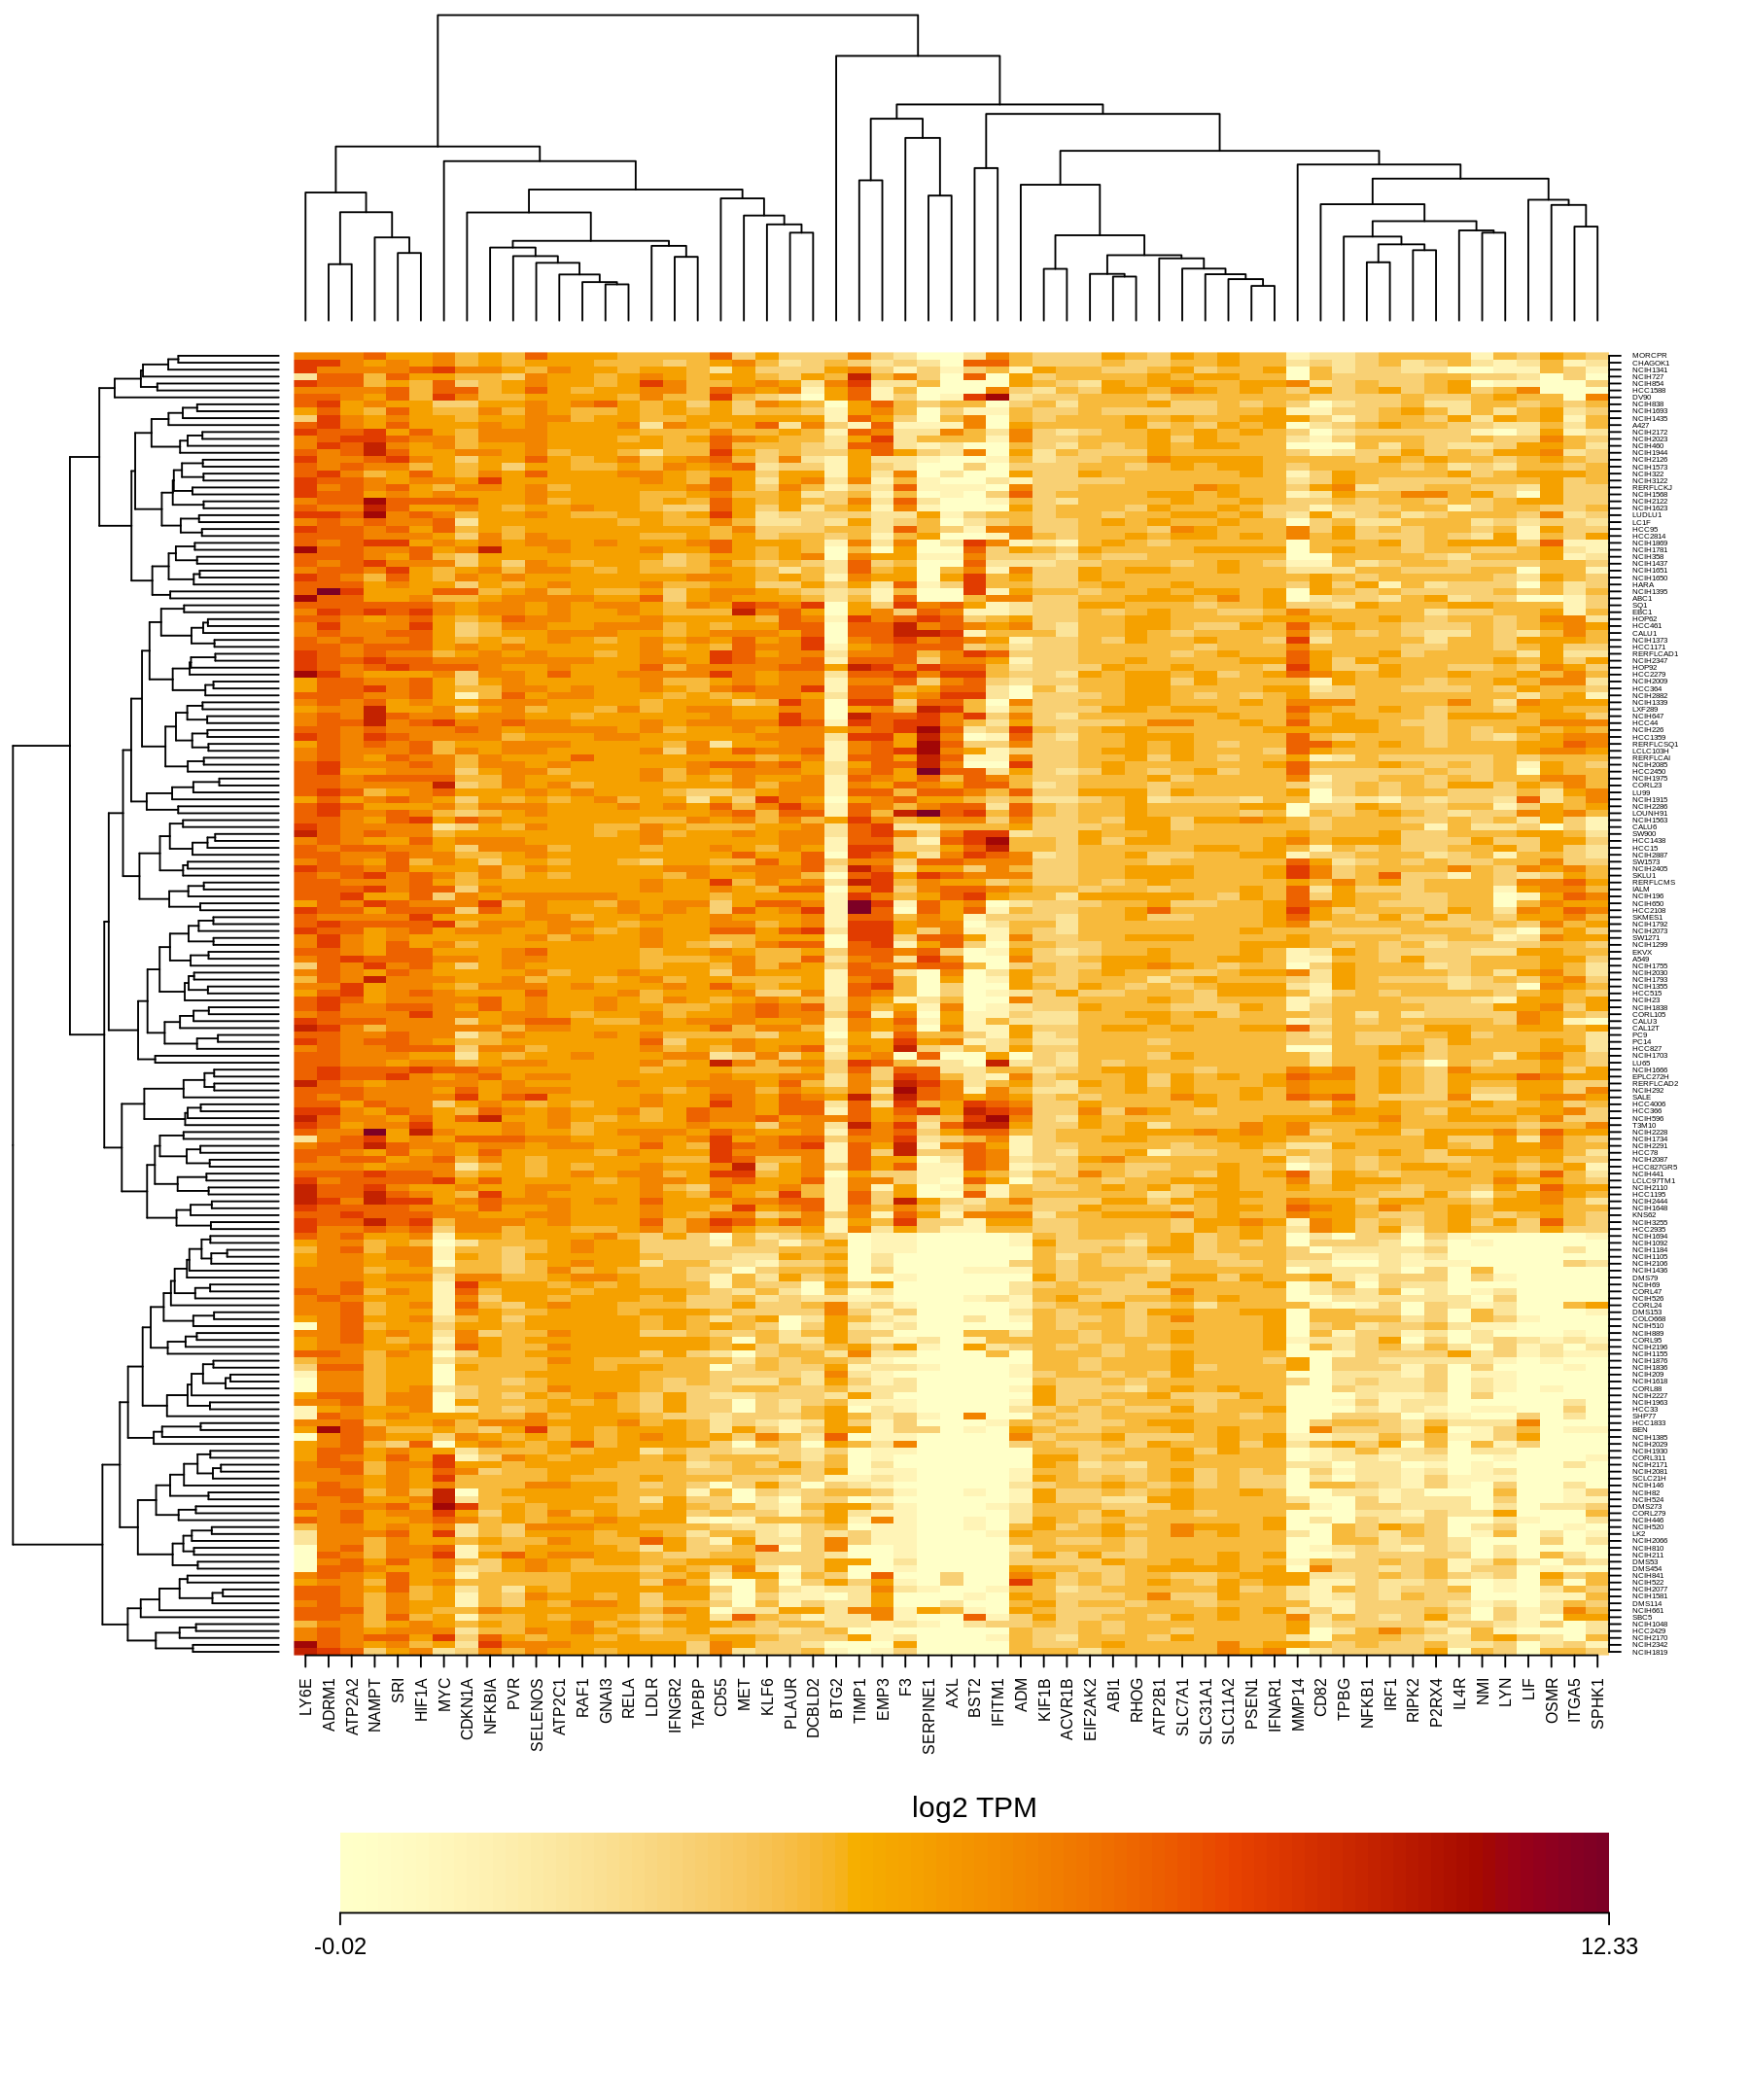

In [28]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=12, repr.plot.res=180)
# layout our plot
graphics::layout(
    matrix(c(
        5,2,2,2,2,6,
        1,3,3,3,3,4,
        1,3,3,3,3,4,
        1,3,3,3,3,4,
        1,3,3,3,3,4,
        1,3,3,3,3,4
    ), ncol=6))
# plot genes dengrogram
par(mar=c(0,0.5,0,6.5)+0.1)
plot(col_cl, labels = FALSE, hang = -0.1, axes = FALSE, ann = FALSE, xaxs="i")
# plot samples dendrogram
par(mar=c(4,0,0,0)+0.1)
plot(as.dendrogram(rw_cl), leaflab = 'none', axes = FALSE, ann = FALSE, horiz=TRUE, yaxs="i")
# plot the heatmap
par(mar=c(4,0,0,6)+0.1)
image(x=0:ncol(ltpm), y=0:nrow(ltpm), z=t(ltpm), axes=FALSE, xlab=NA, ylab=NA)
axis(4, at=1:nrow(ltpm)-0.5, labels=gsub("_LUNG", "", rownames(ltpm)), las=2, cex.axis=0.4)
axis(1, at=1:ncol(ltpm)-0.5, labels=colnames(ltpm), las=3, cex.axis=0.8)
# add a legend
leg <- matrix(seq(min(ltpm), max(ltpm), length.out=100), ncol=100)
leg <- rbind(leg, rep(NA, 100))
par(mar=c(8,2,0,6)+0.1)
image(x=0:100, y=0:1, z=t(leg), col = hcl.colors(100, "YlOrRd", rev = TRUE), axes=FALSE, xlab=NA, ylab=NA)
mtext("log2 TPM", line=-3, at=50)
axis(1, at=c(0, 100), labels=round(c(min(ltpm), max(ltpm)),2), cex.axis=1.2)

Ctrl+scroll to zoom in on sample names.